# Generator de întrebări în funcție de dificultate

### Biblioteci

In [49]:
# %pip install matplotlib
# %pip install pandas
# %pip install numpy
# %pip install scipy
# %pip install nltk
# %pip install scikit-learn
# %pip install seaborn
# %pip install transformers

### Citire Date

In [50]:
import pandas as pd

with open("dataset.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

context_text = "".join(lines[1:]).strip()

print(context_text)

In this book, we’ll use the public Internet, a specific computer network, as our principal
vehicle for discussing computer networks and their protocols. But what is the
Internet? There are a couple of ways to answer this question. First, we can describe
the nuts and bolts of the Internet, that is, the basic hardware and software components
that make up the Internet. Second, we can describe the Internet in terms of a networking
infrastructure that provides services to distributed applications. Let’s begin
with the nuts-and-bolts description, using Figure 1.1 to illustrate our discussion.
The Internet is a computer network that interconnects hundreds of millions of computing
devices throughout the world. Not too long ago, these computing devices were
primarily traditional desktop PCs, Linux workstations, and so-called servers that store
and transmit information such as Web pages and e-mail messages. Increasingly,
however, nontraditional Internet end systems such as laptops, smartphones, 

In [51]:
print(type(context_text))

<class 'str'>


### Generare Întrebări

In [52]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

model_name = "valhalla/t5-base-e2e-qg"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [53]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [54]:
sentences = sent_tokenize(context_text)

chunk_size = 2
chunks = [" ".join(sentences[i:i + chunk_size]) for i in range(0, len(sentences), chunk_size)]

all_questions = []

for idx, chunk in enumerate(chunks, 1):

    input_text = "generate questions: " + chunk
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

    output_ids = model.generate(
        input_ids=input_ids,
        max_length=256,
        num_beams=4,
        length_penalty=1.5,
        no_repeat_ngram_size=3,
        early_stopping=True
    )

    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    questions = decoded.split("<sep>") if "<sep>" in decoded else [decoded]

    for q in questions:
      all_questions.append({
          "context": chunk,
          "question": q.strip()
      })

In [55]:
print("\nTotal întrebări generate:", len(all_questions))
print("\nExemplu:")
print(all_questions[0])


Total întrebări generate: 89

Exemplu:
{'context': 'In this book, we’ll use the public Internet, a specific computer network, as our principal\nvehicle for discussing computer networks and their protocols. But what is the\nInternet?', 'question': 'What is the name of the computer network discussed in this book?'}


### Euristică

In [56]:
from nltk.corpus import stopwords, wordnet as wn
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.tokenize import word_tokenize
import string

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
heuristic_model = SentenceTransformer('all-MiniLM-L6-v2')

def ambiguity_score(question):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(question.lower())

    # eliminare semne de punctuatie si stopwords
    filtered_tokens = [
        t for t in tokens
        if t not in stop_words and t not in string.punctuation
    ]

    # calculam numarul de sensuri pentru fiecare cuvant valid
    senses = [len(wn.synsets(t)) for t in filtered_tokens if wn.synsets(t)]

    if senses:
        avg_senses = sum(senses) / len(senses)
    else:
        # caz in care nu exista cuvinte semnificative
        avg_senses = 0

    return avg_senses

In [58]:
def semantic_similarity(context, question):

    embeddings = heuristic_model.encode([context, question], convert_to_tensor=True)
    score = util.cos_sim(embeddings[0], embeddings[1])
    return float(score)

In [59]:
context = """
The Internet is a computer network that interconnects millions of computing devices throughout the world. These devices include not just traditional PCs, but also smartphones, tablets, TVs, and even home appliances. End systems are connected by communication links and packet switches. The Internet uses protocols like TCP and IP to transfer information between devices.
"""

question = "What protocols does the Internet use to transfer data?"

ambiguity = ambiguity_score(question)
similarity = semantic_similarity(context, question)

ambiguity, similarity

(6.8, 0.6581790447235107)

In [60]:
def difficulty_score(question, context, alpha=0.6, beta=0.4):
    amb = ambiguity_score(question)
    sim = semantic_similarity(question, context)
    difficulty = alpha * amb + beta * (1 - sim)
    return difficulty

In [61]:
context = "The Internet is a global network of computers that communicate using protocols like TCP/IP."
question = "What is the Internet?"

print("Scor dificultate:", difficulty_score(question, context))

Scor dificultate: 0.6920180797576905


In [62]:
alpha = 0.6
beta = 0.4

for item in all_questions:

  question = item["question"]
  context = item["context"]

  ambig = ambiguity_score(question)
  sim_score = semantic_similarity(context, question)

  diff = alpha * ambig + beta * (1 - sim_score)

  item["ambiguity_score"] = ambig
  item["similarity_score"] = sim_score
  item["difficulty"] = diff

print(all_questions[0])

{'context': 'In this book, we’ll use the public Internet, a specific computer network, as our principal\nvehicle for discussing computer networks and their protocols. But what is the\nInternet?', 'question': 'What is the name of the computer network discussed in this book?', 'ambiguity_score': 8.0, 'similarity_score': 0.6202012300491333, 'difficulty': 4.951919507980347}


### Alegere dificultate întrebări

In [63]:
import pandas as pd

df = pd.DataFrame(all_questions)

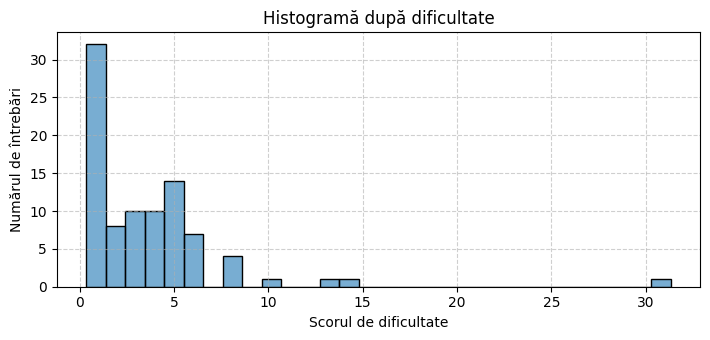

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7.2, 3.5))
sns.histplot(data=df, x="difficulty", bins=30, alpha=0.6)
plt.title("Histogramă după dificultate")
plt.xlabel('Scorul de dificultate')
plt.ylabel('Numărul de întrebări')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [65]:
# ce este peste 5 e greu
# ce este intre 2 si 5 e mediu
# restul sunt usoare

def classify_difficulty(score):
    if score < 2.0:
        return "easy"
    elif score < 5.0:
        return "medium"
    else:
        return "hard"

num_questions = 25

In [67]:
difficulty_to_be = "medium"
filtered_questions = []

while len(filtered_questions) < num_questions:

  for chunk in chunks:

    input_text = "generate questions: " + chunk
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

    output_ids = model.generate(
        input_ids=input_ids,
        max_length=256,
        num_beams=4,
        length_penalty=1.5,
        no_repeat_ngram_size=3,
        early_stopping=True
    )

    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    questions = decoded.split("<sep>") if "<sep>" in decoded else [decoded]

    for item in questions:

      question = item.strip()
      context = chunk

      ambig = ambiguity_score(question)
      sim_score = semantic_similarity(context, question)

      diff = alpha * ambig + beta * (1 - sim_score)

      if classify_difficulty(diff) == difficulty_to_be:
          filtered_questions.append({
            "context": chunk,
            "question": question,
            "difficulty_score": diff
          })

      if len(filtered_questions) > num_questions:
        break

In [69]:
for iter in range(len(filtered_questions)):

  print(filtered_questions[iter])

{'context': 'In this book, we’ll use the public Internet, a specific computer network, as our principal\nvehicle for discussing computer networks and their protocols. But what is the\nInternet?', 'question': 'What is the name of the computer network discussed in this book?', 'difficulty_score': 4.951919507980347}
{'context': 'There are a couple of ways to answer this question. First, we can describe\nthe nuts and bolts of the Internet, that is, the basic hardware and software components\nthat make up the Internet.', 'question': 'What are the nuts and bolts of the internet?', 'difficulty_score': 4.903491592407226}
{'context': 'Second, we can describe the Internet in terms of a networking\ninfrastructure that provides services to distributed applications. Let’s begin\nwith the nuts-and-bolts description, using Figure 1.1 to illustrate our discussion.', 'question': 'What can we describe the Internet in terms of?', 'difficulty_score': 3.105325198173523}
{'context': 'Second, we can describe